<a href="https://colab.research.google.com/github/OlegBEZb/CV2_UVA_assignments/blob/master/DeepLearningBasedFaceSwap_Oleg_blending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Based Face Swap

# Intro

Generating images or videos by manipulating facial attributes (i.e. face reenactment and swapping) has gained a lot of attention in recent years due to their broad range of computer vision and multimedia applications such as video dubbing, gaze correction, actor capturing, and virtual avatar creation. Imagine, old Mark Hamill could act as a young Luke Skywalker, or a stuntman acting as Daniel Craig. In this tutorial, you will play with a face swapping pipeline based on 2D-to-3D reconstruction.

The task of face reenactment is to change attribute of a face image (i.e. pose, expression or light), while *face swapping* is focused on changing face identity of an image while keeping other attributes (pose, expression and background) the same. Face identity can be defined as a set of attributes which identifies a person. It can range from a skin / eye colors to face geometry and expression. Ignoring geometrical changes and lighting condition, one can approximate facial identity purely by a texture of the face region.

# Environment preparation

Before everything, please add a shortcut to this Google Drive directory: https://drive.google.com/drive/folders/1EEdqNgK8xN-gqJO5-NLv4PGH5_dU7zna?usp=sharing

Download BFM 2009 model from here https://faces.dmi.unibas.ch/bfm/index.php?nav=1-2&id=downloads (BFM 2009 used in this part of the assignment is different from BFM 2017 used in the other part).

In [1]:
## Mounts Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# %tensorflow_version 2.x
# !pip uninstall -y tensorflow
# !pip install tensorflow==1.13.1
# !pip install tensorflow-gpu==1.13.1

Mounted at /content/gdrive


In [ ]:
# import tensorflow as tf
# print(tf.__version__)

In [ ]:
# !cp /content/gdrive/MyDrive/CV2/cv2_2021_assignment3.zip . 
# !unzip cv2_2021_assignment3.zip
# !mv Assignment3/cv2_2021_assignment3 .

cp: cannot stat '/content/gdrive/MyDrive/CV2/cv2_2021_assignment3.zip': No such file or directory
unzip:  cannot find or open cv2_2021_assignment3.zip, cv2_2021_assignment3.zip.zip or cv2_2021_assignment3.zip.ZIP.
mv: cannot stat 'Assignment3/cv2_2021_assignment3': No such file or directory


In [ ]:
# !unzip /content/gdrive/MyDrive/CV_2/data_set/data_set/data.zip -d /content/gdrive/MyDrive/CV_2/data_set/data_set/data

In [ ]:
# import os
# len(os.listdir('/content/gdrive/MyDrive/CV_2/data_set/data/'))

39544

Copying weights and metadata from Google Drive. Before running the code below, put ``01_MorphableModel.mat`` you have downloaded before into the Google Drive folder. If you have ``01_MorphableModel.mat`` somewhere else, you can change the path.

In [ ]:
!cp -v /content/gdrive/MyDrive/01_MorphableModel.mat cv2_2021_assignment3/BFM
!cp -v /content/gdrive/MyDrive/CV2/Exp_Pca.bin cv2_2021_assignment3/BFM

!mkdir -p cv2_2021_assignment3/network
!cp -v /content/gdrive/MyDrive/CV2/FaceReconModel.pb cv2_2021_assignment3/network

'/content/gdrive/MyDrive/01_MorphableModel.mat' -> 'cv2_2021_assignment3/BFM/01_MorphableModel.mat'
'/content/gdrive/MyDrive/CV2/Exp_Pca.bin' -> 'cv2_2021_assignment3/BFM/Exp_Pca.bin'
'/content/gdrive/MyDrive/CV2/FaceReconModel.pb' -> 'cv2_2021_assignment3/network/FaceReconModel.pb'


Installing face analysis dependencies.

In [ ]:
# Needed to generate the facial landmarks
!pip install https://github.com/cmusatyalab/openface/archive/0.2.1.zip
!pip install dlib
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 && bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

  Using cached https://github.com/cmusatyalab/openface/archive/0.2.1.zip
--2022-04-07 18:12:45--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  38.7MB/s    in 1.6s    

2022-04-07 18:12:46 (38.7 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


Building other dependencies.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf

TF_LIB = tf.sysconfig.get_lib()

!cp -v $TF_LIB/libtensorflow_framework.so.1 /usr/lib/
!cd /usr/lib/ && ln -s libtensorflow_framework.so.1 libtensorflow_framework.so
!cd /content/cv2_2021_assignment3/tf_mesh_renderer;\
  sed -i -r ':a;N;$!ba;s/def get_libraries\(self, ext\):(\n\s*)/def get_libraries(self, ext):\1return None\1/g' setup.py

!cd /content/cv2_2021_assignment3/tf_mesh_renderer && python setup.py install

cp: cannot stat '/usr/local/lib/python3.7/dist-packages/tensorflow/libtensorflow_framework.so.1': No such file or directory
/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'install_requires'
  warnings.warn(msg)
running install
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
copying mesh_renderer.py -> build/lib.linux-x86_64-3.7
copying camera_utils.py -> build/lib.linux-x86_64-3.7
copying rasterize_triangles.py -> build/lib.linux-x86_64-3.7
running build_ext
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future 

# Implementation

Given two images, foreground and background, the task of face swapping is to change identity of the background image into foreground while keeping all other attributes (pose, expression, environment etc.) to be the same.

Below are preset foreground and background images. To play with other images, upload to the Google Drive folder first and change paths.




In [ ]:
%cd /content/cv2_2021_assignment3

/content/cv2_2021_assignment3


In [ ]:
fg_path = "/content/gdrive/MyDrive/CV2/clinton.jpg"
bg_path = "/content/gdrive/MyDrive/CV2/trump.jpg"

In [ ]:
import cv2
import dlib
import openface
import numpy as np

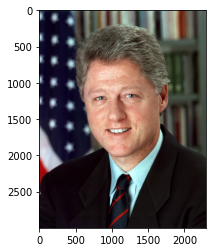

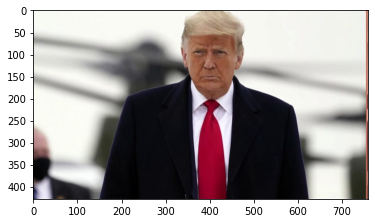

In [ ]:
# Reading background and foreground
fg = cv2.imread(fg_path)
bg = cv2.imread(bg_path)

import matplotlib.pyplot as plt
plt.imshow(fg[...,::-1])
plt.show()
plt.imshow(bg[...,::-1])
plt.show()

## Landmark Extraction

To perform face swapping, first we need to localize face region. It can be achieved by detecting a face and its facial landmarks. Landmark prediction algorithm from dlib, used in this tutorial, provides 68 facial landmarks cover chin, eye, eybrows, nose and mouth regions.

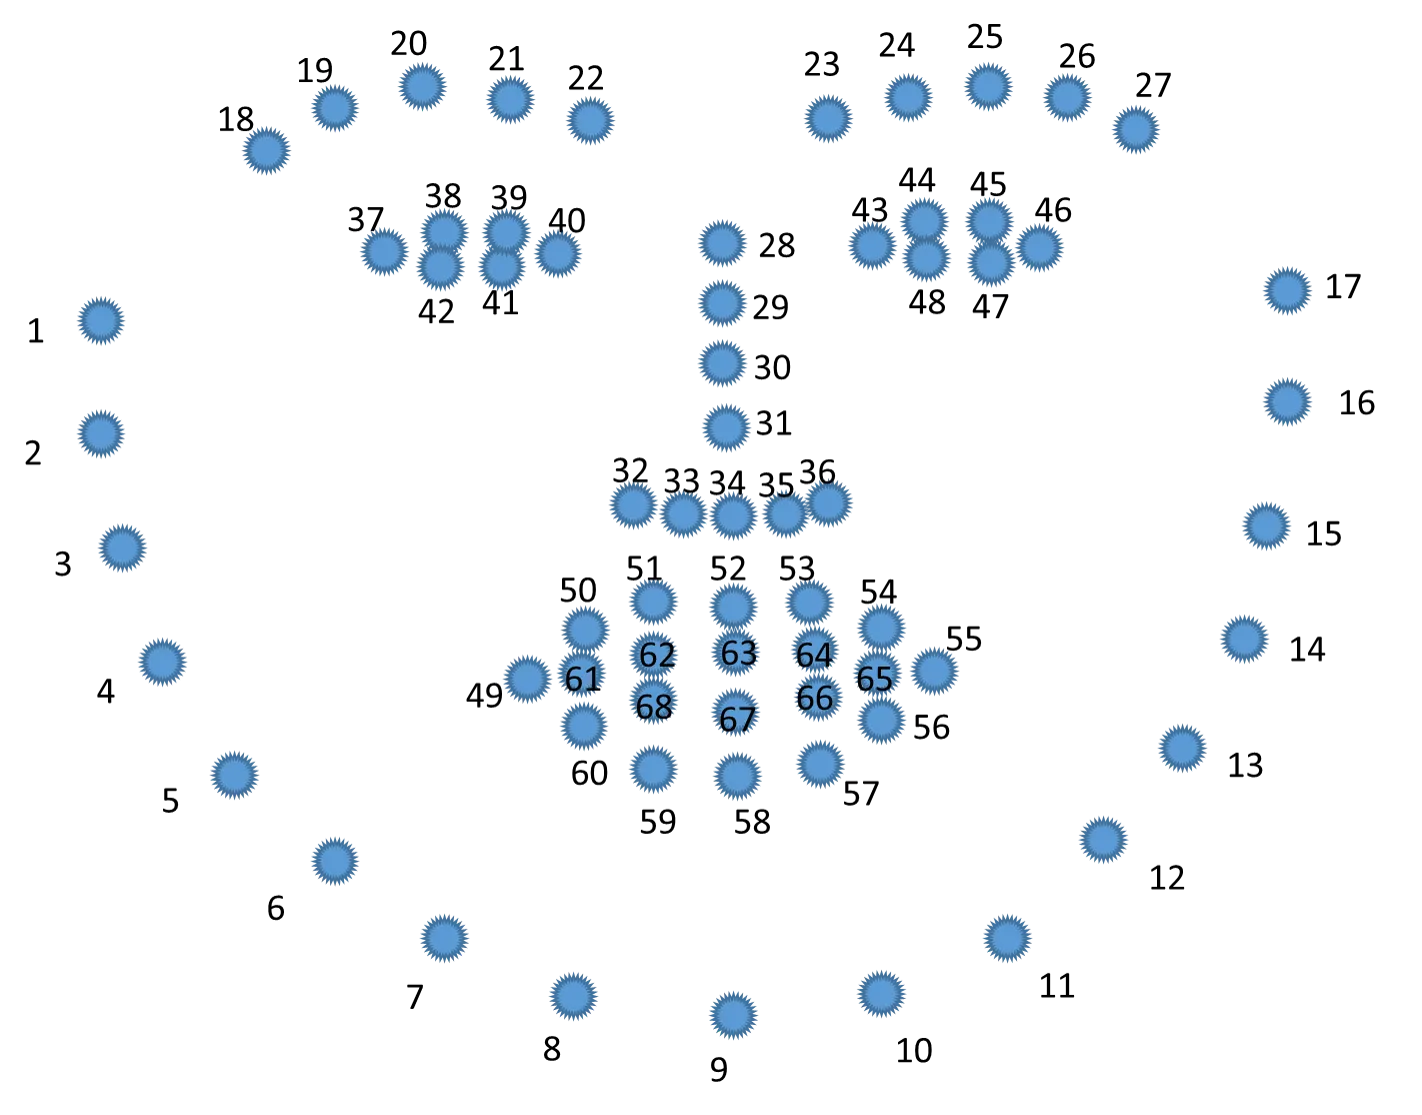

In [ ]:
# Face Detector
detector = dlib.get_frontal_face_detector()
# Landmark Detector
predictor = openface.AlignDlib("/content/shape_predictor_68_face_landmarks.dat")

def predict_landmarks(img):
  dets = detector(img, 1)
  if len(dets) < 1:
    return None # Face Not Found
  
  print("Found %d faces" % len(dets))
  d = dets[0]
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  landmarks = predictor.findLandmarks(gray_img, d)
  return np.asarray(landmarks)

In [ ]:
fg_landmarks = predict_landmarks(fg)
bg_landmarks = predict_landmarks(bg)

Found 1 faces
Found 1 faces


In [ ]:
def visualize_landmarks(img, landmarks, radius=2):
  new_img = np.copy(img)
  h, w, _ = new_img.shape
  for x, y in landmarks:
    x = int(x)
    y = int(y)
    new_img[max(0,y-radius):min(h-1,y+radius),max(0,x-radius):min(w-1,x+radius)] = (255, 0, 0)
  plt.imshow(new_img[...,::-1])
  plt.show()

If you don't see any blue points, increase the radius parameter.

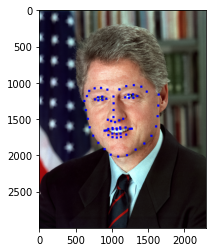

In [ ]:
visualize_landmarks(fg, fg_landmarks, radius=15)

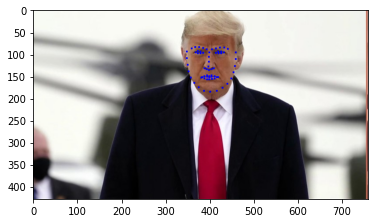

In [ ]:
visualize_landmarks(bg, bg_landmarks, radius=2)

**Exercise 1:** Face landmark detection is quite a challenging task on extreme boundary cases (with extreme pose, expression, or lighting). Try out with different images to evaluate the robustness of the landmark detection algorithm.

## Crop face images based on landmarks

Given facial landmarks, face region and be localized and cropped.

In [ ]:
from preprocess_img import Preprocess
from PIL import Image
from load_data import *

# read standard landmarks for preprocessing images
lm3D = load_lm3d()

def crop_image(img, landmarks):
  lm5 = np.zeros((5, 2), dtype=np.float32)
  lm5[0] = (landmarks[36] + landmarks[39]) / 2
  lm5[1] = (landmarks[42] + landmarks[45]) / 2
  lm5[2] = landmarks[30]
  lm5[3] = landmarks[48]
  lm5[4] = landmarks[54]
  input_img, lm_new, transform_params = Preprocess(Image.fromarray(img[...,::-1]), lm5, lm3D)

  return input_img, lm_new

In [ ]:
fg_cropped, fg_cropped_lm = crop_image(fg, fg_landmarks)
bg_cropped, bg_cropped_lm = crop_image(bg, bg_landmarks)

/content/cv2_2021_assignment3/preprocess_img.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  k,_,_,_ = np.linalg.lstsq(A,b)
/content/cv2_2021_assignment3/preprocess_img.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trans_params = np.array([w0,h0,102.0/s,t[0],t[1]])


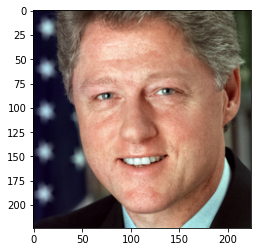

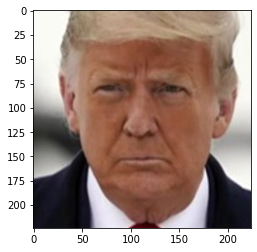

In [ ]:
plt.imshow(fg_cropped[0, ..., ::-1])
plt.show()

plt.imshow(bg_cropped[0, ..., ::-1])
plt.show()

## Naive face swapping implementation



One way to naively swap two faces is to detect the face region of the foreground image, crop it and put it on top of the background image.

Found 1 faces


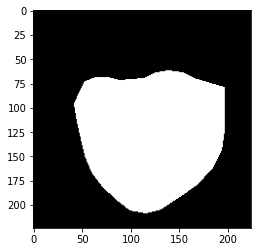

In [ ]:
fg_cropped_lm = predict_landmarks(fg_cropped[0]).astype(np.int32)

mask = np.zeros(fg_cropped[0].shape, dtype=np.uint8)
roi_corners = np.array([np.concatenate((fg_cropped_lm[:17], # chin
                                        fg_cropped_lm[17:27][::-1], # eyebrows
                                        ), axis=0)], dtype=np.int32)
channel_count = fg_cropped[0].shape[2]
ignore_mask_color = (255,)*channel_count
cv2.fillPoly(mask, roi_corners, ignore_mask_color)

plt.imshow(mask)
plt.show()

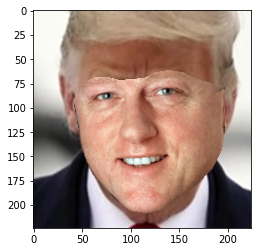

In [ ]:
swapped = np.where(mask, fg_cropped[0], bg_cropped[0])
plt.imshow(swapped[..., ::-1])
plt.show()

**Face swap with 3D alignment**

Now, if one can reconstruct a 3D model of two faces and determine their head pose and facial expression, expression and pose of the background face can be applied on the foreground face before merging them together.

In [ ]:
from face_swap import FaceSwap
fs = FaceSwap()

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.13.1


Please ignore tensorflow errors if a swapped face is returned.

In [ ]:
swapped = fs.swap(fg_cropped, bg_cropped)

0.007932885 0.991364 0.065844 0.96091604
CE (30762, 30730)
Found polygon 551 edges
CE (9547, 9667)
Found polygon 78 edges
solution 0, area 4.79062094
solution 1, area 4.79041515
solution 2, area 4.79041515
solution 3, area 4.88589069
solution 4, area 4.86822446
solution 5, area 4.86822446
solution 6, area 4.99695566
solution 7, area 0.59468630
solution 8, area 0.59468630
solution 9, area 0.58488773
solution 10, area 0.58330777
solution 11, area 0.58326968
solution 12, area 0.58326968
solution 13, area 0.58355257
solution 14, area 0.58885693
solution 15, area 0.60444692
solution 16, area 5.74373500
solution 17, area 5.62663873
solution 18, area 5.58337348
solution 19, area 5.55091789
solution 20, area 5.53081906
solution 21, area 5.51701157
solution 22, area 5.51701157
solution 23, area 5.51703095
solution 24, area 5.51710401
solution 25, area 5.51731102
solution 26, area 5.51041154
solution 27, area 5.50720142
solution 28, area 5.50720142
solution 29, area 5.50721243
solution 30, area 

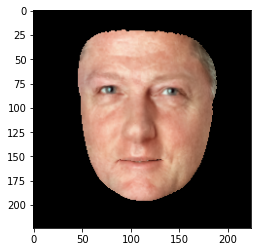

In [ ]:
plt.imshow(swapped)
plt.show()

Now we can combine a swapped face with background.

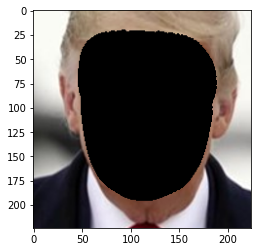

In [ ]:
mask = np.tile(np.any(swapped > 0, axis=2, keepdims=True), (1, 1, 3))

bg = np.copy(bg_cropped[0][..., ::-1])

# Sets all foreground pixel to 0
bg[mask] = 0

plt.imshow(bg)
plt.show()

In [ ]:
output = np.where(mask, swapped, bg)

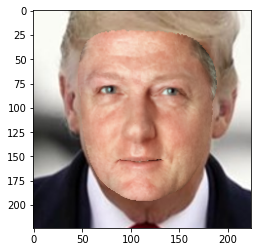

In [ ]:
plt.imshow(output)
plt.show()

## Face Blending

The final step of the face swapping pipeline is to blend swapped face with background.

In this section, we will implement a blending pipeline that takes as input the 1) source image, 2) the 3D reconstruction that you obtain from the previous steps, and 3) the target image. The pipeline will output a single image that is then blended 3D mask onto the target, which should make it look more natural.

In [8]:
!rm -rf CV2_UVA_assignments/

In [9]:
!git clone https://github.com/OlegBEZb/CV2_UVA_assignments.git 

Cloning into 'CV2_UVA_assignments'...
remote: Enumerating objects: 524, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 524 (delta 184), reused 181 (delta 87), pack-reused 241
Receiving objects: 100% (524/524), 37.36 MiB | 34.84 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [10]:
!python /content/CV2_UVA_assignments/assignment3/src/gan_blender_release/train_blender.py

[X] WARN: No GPU Devices found on the system! Using the CPU. Execution maybe slow!
[I] STATUS: Initiate Network and transfer to device...
generator, discriminator devices are GPU False False
✓
[I] STATUS: Load Networks...
generator, discriminator devices are GPU False False
✓
[I] STATUS: Initiate optimizer...✓
[I] STATUS: Initiate Criterions and transfer to device...✓
[I] STATUS: Initiate Dataloaders...
initialized with 35712 files. first path is /content/gdrive/MyDrive/CV_2/data_set/data/10000_bg_27998.png
different groups: 8928. first group: ['/content/gdrive/MyDrive/CV_2/data_set/data/10000_bg_27998.png', '/content/gdrive/MyDrive/CV_2/data_set/data/10000_fg_18999.png', '/content/gdrive/MyDrive/CV_2/data_set/data/10000_mask_27998_18999.png', '/content/gdrive/MyDrive/CV_2/data_set/data/10000_sw_27998_18999.png']
initialized with 3832 files. first path is /content/gdrive/MyDrive/CV_2/data_set/val_data/0000_bg_9999.png
different groups: 958. first group: ['/content/gdrive/MyDrive/CV_2/d

In [82]:
import os
filenames = sorted(os.listdir('/content/gdrive/MyDrive/CV_2/data_set/data'))
len(filenames)

39544

In [89]:
len(os.listdir('/content/gdrive/MyDrive/CV_2/data_set/data'))

35712

In [90]:
len(os.listdir('/content/gdrive/MyDrive/CV_2/data_set/val_data'))

3832

In [ ]:
# [os.rename(os.path.join('/content/gdrive/MyDrive/CV_2/data_set/data', f), 
#            os.path.join('/content/gdrive/MyDrive/CV_2/data_set/val_data', f)) for f in filenames if int(f[:4]) < 1000]

In [21]:
from collections import defaultdict
group2path_mapping = defaultdict(list)
import os
file_paths = os.listdir(os.path.join(home_path, 'data_2'))
for file_path in file_paths:
    group2path_mapping[file_path.split('/')[-1].split('_')[0]].append(file_path)

In [22]:
len(group2path_mapping)

9886

In [8]:
import os
import cv2
import matplotlib.pyplot as plt

In [12]:
home_path = '/content/gdrive/MyDrive/CV_2/data_set'

In [61]:
# Reading background and foreground
fg = cv2.imread(os.path.join(home_path, 'data', '0000_fg_0.png'))
sw = cv2.imread(os.path.join(home_path, 'data', '0000_sw_9999_0.png'))
mask = cv2.imread(os.path.join(home_path, 'data', '0000_mask_9999_0.png'))
bg = cv2.imread(os.path.join(home_path, 'data', '0000_bg_9999.png'))

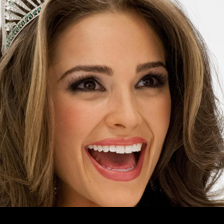

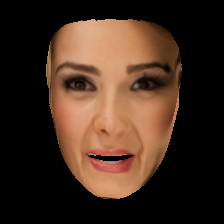

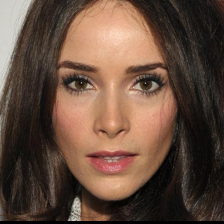

In [63]:
from google.colab.patches import cv2_imshow
cv2_imshow(fg)
cv2_imshow(sw)
cv2_imshow(bg)

In [64]:
import numpy as np
mask = np.where(mask > 0, 1, mask)
mask.shape

(224, 224, 3)

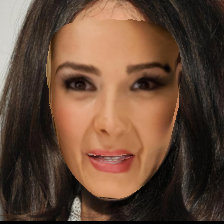

In [68]:
def transfer_mask(img1, img2, mask):
    # face reenacted to the background face without face
    return img1 * mask  + img2 * (1 - mask)
    
overlaid = transfer_mask(sw, bg, mask)
cv2_imshow(overlaid)

In [69]:
from CV2_UVA_assignments.assignment3.src.gan_blender_release import img_utils


def blend_imgs_bgr(source_img, target_img, mask):
    # Implement poisson blending here. You can use the built-in seamlessClone
    # function in opencv which is an implementation of Poisson Blending.
    a = np.where(mask != 0)
    if len(a[0]) == 0 or len(a[1]) == 0:
        return target_img
    if (np.max(a[0]) - np.min(a[0])) <= 10 or (np.max(a[1]) - np.min(a[1])) <= 10:
        return target_img

    center = (np.min(a[1]) + np.max(a[1])) // 2, (np.min(a[0]) + np.max(a[0])) // 2
    output = cv2.seamlessClone(source_img, target_img, mask * 255, center, cv2.NORMAL_CLONE)

    return output


def blend_imgs(source_tensor, target_tensor, mask_tensor):
    out_tensors = []
    for b in range(source_tensor.shape[0]):
        source_img = img_utils.tensor2bgr(source_tensor[b])
        target_img = img_utils.tensor2bgr(target_tensor[b])
        mask = mask_tensor[b].permute(1, 2, 0).cpu().numpy()
        mask = np.round(mask * 255).astype('uint8')
        out_bgr = blend_imgs_bgr(source_img, target_img, mask)
        out_tensors.append(img_utils.bgr2tensor(out_bgr))

    return torch.cat(out_tensors, dim=0)

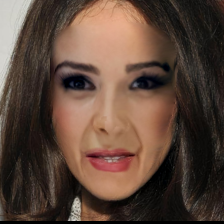

In [71]:
blended = blend_imgs_bgr(sw, bg, mask)
cv2_imshow(blended)

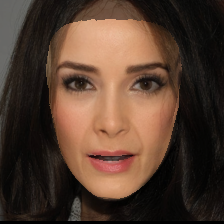

In [81]:
alpha = 0.5
alpha_blend = cv2.addWeighted(src1=sw, alpha=alpha, src2=bg, beta=1-alpha, gamma=0)
cv2_imshow(alpha_blend)